# Colorize grayscale images using 🎨 DDColor and OpenVINO

Image colorization is the process of adding color to grayscale images. Initially captured in black and white, these images are transformed into vibrant, lifelike representations by estimating RGB colors. This technology enhances both aesthetic appeal and perceptual quality. Historically, artists manually applied colors to monochromatic photographs, a painstaking task that could take up to a month for a single image. However, with advancements in information technology and the rise of deep neural networks, automated image colorization has become increasingly important.

DDColor is one of the most progressive methods of image colorization in our days. It is a novel approach using dual decoders: a pixel decoder and a query-based color decoder, that stands out in its ability to produce photo-realistic colorization, particularly in complex scenes with multiple objects and diverse contexts.
![](https://github.com/piddnad/DDColor/raw/master/assets/network_arch.jpg)

More details about this approach can be found in original model [repository](https://github.com/piddnad/DDColor) and [paper](https://arxiv.org/abs/2212.11613).

In this tutorial we consider how to convert and run DDColor using OpenVINO. Additionally, we will demonstrate how to optimize this model using [NNCF](https://github.com/openvinotoolkit/nncf/).

🪄 Let's start to explore magic of image colorization!
#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Load PyTorch model](#Load-PyTorch-model)
- [Run PyTorch model inference](#Run-PyTorch-model-inference)
- [Convert PyTorch model to OpenVINO Intermediate Representation](#Convert-PyTorch-model-to-OpenVINO-Intermediate-Representation)
- [Run OpenVINO model inference](#Run-OpenVINO-model-inference)
- [Optimize OpenVINO model using NNCF](#Optimize-OpenVINO-model-using-NNCF)
    - [Collect quantization dataset](#Collect-quantization-dataset)
    - [Perform model quantization](#Perform-model-quantization)
- [Run INT8 model inference](#Run-INT8-model-inference)
- [Compare FP16 and INT8 model size](#Compare-FP16-and-INT8-model-size)
- [Compare inference time of the FP16 and INT8 models](#Compare-inference-time-of-the-FP16-and-INT8-models)
- [Interactive inference](#Interactive-inference)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/ddcolor-image-colorization/ddcolor-image-colorization.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [1]:
import platform


if platform.system() == "Darwin":
    %pip install -q "numpy<2.0.0"


%pip install -q "nncf>=2.11.0" "torch>=2.1" "torchvision" "timm" "opencv_python" "pillow" "PyYAML" "scipy" "scikit-image" "datasets" "gradio>=4.19"  --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -Uq "openvino>=2024.3.0"

In [2]:
from pathlib import Path
import requests


if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )
    open("notebook_utils.py", "w").write(r.text)

if not Path("cmd_helper.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/cmd_helper.py",
    )
    open("cmd_helper.py", "w").write(r.text)

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("ddcolor-image-colorization.ipynb")

1491

In [3]:
from cmd_helper import clone_repo


clone_repo("https://github.com/piddnad/DDColor.git")

PosixPath('DDColor')

In [4]:
if Path("DDColor/inference").exists():
    try:
        from inference.colorization_pipeline_hf import DDColorHF, ImageColorizationPipelineHF
    except Exception:
        from inference.colorization_pipeline_hf import DDColorHF, ImageColorizationPipelineHF
else:
    try:
        from infer_hf import DDColorHF, ImageColorizationPipelineHF
    except Exception:
        from infer_hf import DDColorHF, ImageColorizationPipelineHF

/home/ea/work/py311/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## Load PyTorch model
[back to top ⬆️](#Table-of-contents:)

There are several models from DDColor's family provided in [model repository](https://github.com/piddnad/DDColor/blob/master/MODEL_ZOO.md). We will use DDColor-T, the most lightweight version of ddcolor model, but demonstrated in the tutorial steps are also applicable to other models from DDColor family. 

In [5]:
import torch

model_name = "ddcolor_paper_tiny"

ddcolor_model = DDColorHF.from_pretrained(f"piddnad/{model_name}")


colorizer = ImageColorizationPipelineHF(model=ddcolor_model, input_size=512)

ddcolor_model.to("cpu")
colorizer.device = torch.device("cpu")

## Run PyTorch model inference
[back to top ⬆️](#Table-of-contents:)

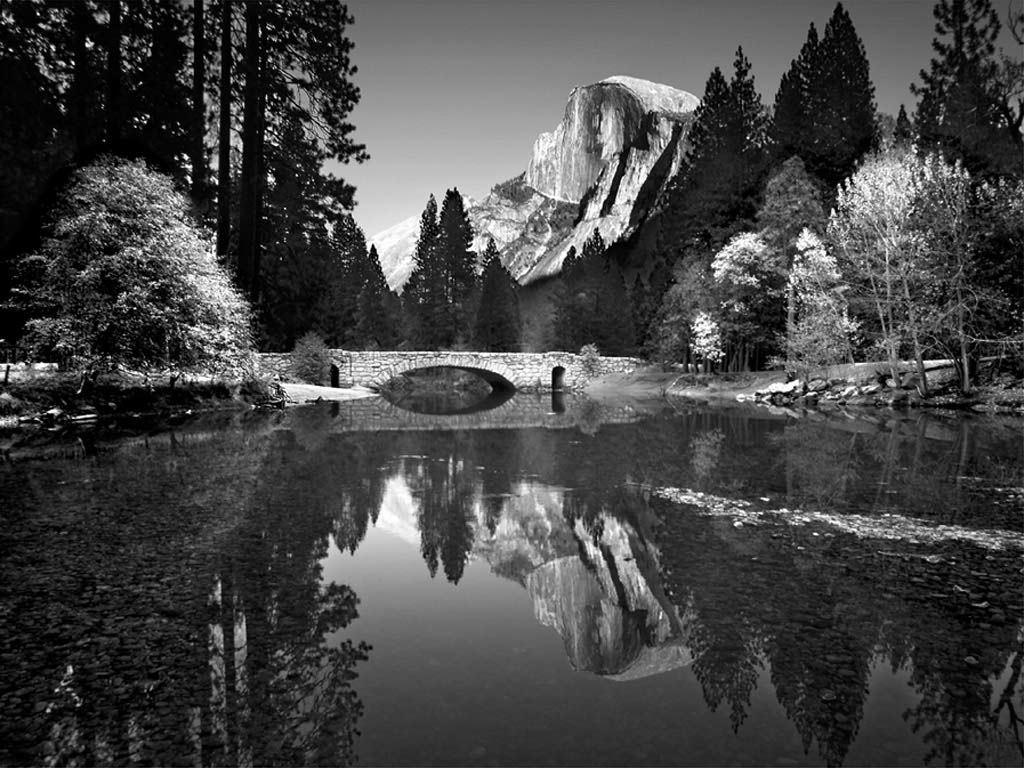

In [6]:
import cv2
import PIL

IMG_PATH = "DDColor/assets/test_images/Ansel Adams _ Moore Photography.jpeg"


img = cv2.imread(IMG_PATH)

PIL.Image.fromarray(img[:, :, ::-1])

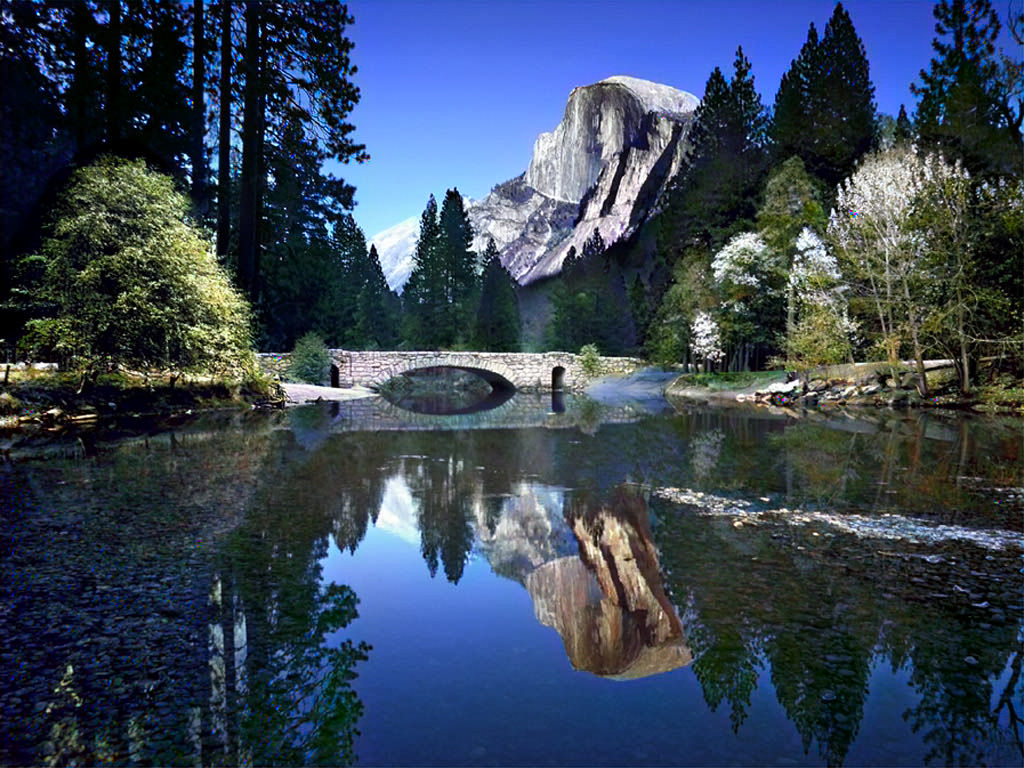

In [7]:
image_out = colorizer.process(img)
PIL.Image.fromarray(image_out[:, :, ::-1])

## Convert PyTorch model to OpenVINO Intermediate Representation
[back to top ⬆️](#Table-of-contents:)

OpenVINO supports PyTorch models via conversion to OpenVINO Intermediate Representation (IR). OpenVINO model conversion API should be used for these purposes. `ov.convert_model` function accepts original PyTorch model instance and example input for tracing and returns `ov.Model` representing this model in OpenVINO framework. Converted model can be used for saving on disk using `ov.save_model` function or directly loading on device using `core.complie_model`.

In [8]:
import openvino as ov
import torch

OV_COLORIZER_PATH = Path("ddcolor.xml")

if not OV_COLORIZER_PATH.exists():
    ov_model = ov.convert_model(ddcolor_model, example_input=torch.ones((1, 3, 512, 512)), input=[1, 3, 512, 512])
    ov.save_model(ov_model, OV_COLORIZER_PATH)

## Run OpenVINO model inference
[back to top ⬆️](#Table-of-contents:)

Select one of supported devices for inference using dropdown list.

In [9]:
from notebook_utils import device_widget

core = ov.Core()

device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [10]:
compiled_model = core.compile_model(OV_COLORIZER_PATH, device.value)

In [11]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F


def process(img, compiled_model):
    # Preprocess input image
    height, width = img.shape[:2]

    # Normalize to [0, 1] range
    img = (img / 255.0).astype(np.float32)
    orig_l = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:, :, :1]  # (h, w, 1)

    # Resize rgb image -> lab -> get grey -> rgb
    img = cv2.resize(img, (512, 512))
    img_l = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:, :, :1]
    img_gray_lab = np.concatenate((img_l, np.zeros_like(img_l), np.zeros_like(img_l)), axis=-1)
    img_gray_rgb = cv2.cvtColor(img_gray_lab, cv2.COLOR_LAB2RGB)

    # Transpose HWC -> CHW and add batch dimension
    tensor_gray_rgb = torch.from_numpy(img_gray_rgb.transpose((2, 0, 1))).float().unsqueeze(0)

    # Run model inference
    output_ab = compiled_model(tensor_gray_rgb)[0]

    # Postprocess result
    # resize ab -> concat original l -> rgb
    output_ab_resize = F.interpolate(torch.from_numpy(output_ab), size=(height, width))[0].float().numpy().transpose(1, 2, 0)
    output_lab = np.concatenate((orig_l, output_ab_resize), axis=-1)
    output_bgr = cv2.cvtColor(output_lab, cv2.COLOR_LAB2BGR)

    output_img = (output_bgr * 255.0).round().astype(np.uint8)

    return output_img

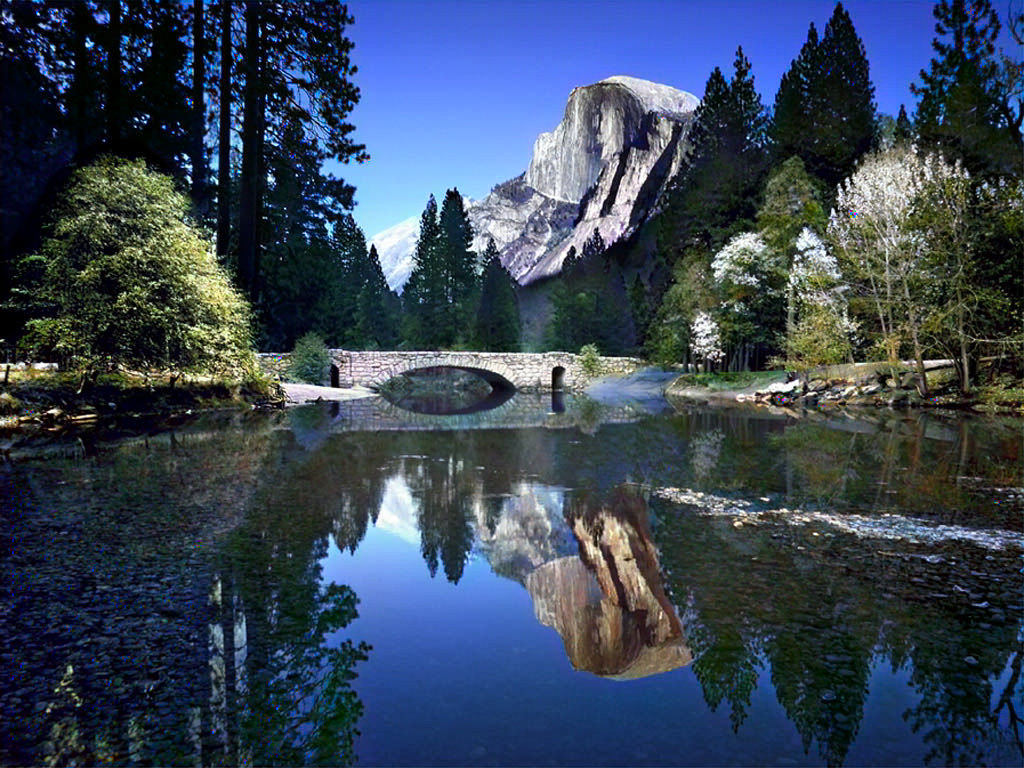

In [12]:
ov_processed_img = process(img, compiled_model)
PIL.Image.fromarray(ov_processed_img[:, :, ::-1])

## Optimize OpenVINO model using NNCF
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.

The optimization process contains the following steps:

1. Create a calibration dataset for quantization.
2. Run `nncf.quantize()` to obtain quantized model.
3. Save the `INT8` model using `openvino.save_model()` function.

Please select below whether you would like to run quantization to improve model inference speed.

In [13]:
from notebook_utils import quantization_widget

to_quantize = quantization_widget()
to_quantize

Checkbox(value=True, description='Quantization')

In [14]:
import requests

OV_INT8_COLORIZER_PATH = Path("ddcolor_int8.xml")
compiled_int8_model = None

if not Path("skip_kernel_extension.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
    )
    open("skip_kernel_extension.py", "w").write(r.text)

%load_ext skip_kernel_extension

### Collect quantization dataset
[back to top ⬆️](#Table-of-contents:)

We use a portion of [`ummagumm-a/colorization_dataset`](https://huggingface.co/datasets/ummagumm-a/colorization_dataset) dataset from Hugging Face as calibration data.

In [15]:
%%skip not $to_quantize.value

from datasets import load_dataset

subset_size = 300
calibration_data = []

if not OV_INT8_COLORIZER_PATH.exists():
    dataset = load_dataset("ummagumm-a/colorization_dataset", split="train", streaming=True).shuffle(seed=42).take(subset_size)
    for idx, batch in enumerate(dataset):
        if idx >= subset_size:
            break
        img = np.array(batch["conditioning_image"])
        img = (img / 255.0).astype(np.float32)
        img = cv2.resize(img, (512, 512))
        img_l = cv2.cvtColor(np.stack([img, img, img], axis=2), cv2.COLOR_BGR2Lab)[:, :, :1]
        img_gray_lab = np.concatenate((img_l, np.zeros_like(img_l), np.zeros_like(img_l)), axis=-1)
        img_gray_rgb = cv2.cvtColor(img_gray_lab, cv2.COLOR_LAB2RGB)

        image = np.expand_dims(img_gray_rgb.transpose((2, 0, 1)).astype(np.float32), axis=0)
        calibration_data.append(image)

### Perform model quantization
[back to top ⬆️](#Table-of-contents:)

In [16]:
%%skip not $to_quantize.value

import nncf

if not OV_INT8_COLORIZER_PATH.exists():
    ov_model = core.read_model(OV_COLORIZER_PATH)
    quantized_model = nncf.quantize(
            model=ov_model,
            subset_size=subset_size,
            calibration_dataset=nncf.Dataset(calibration_data),
        )
    ov.save_model(quantized_model, OV_INT8_COLORIZER_PATH)

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


## Run INT8 model inference
[back to top ⬆️](#Table-of-contents:)

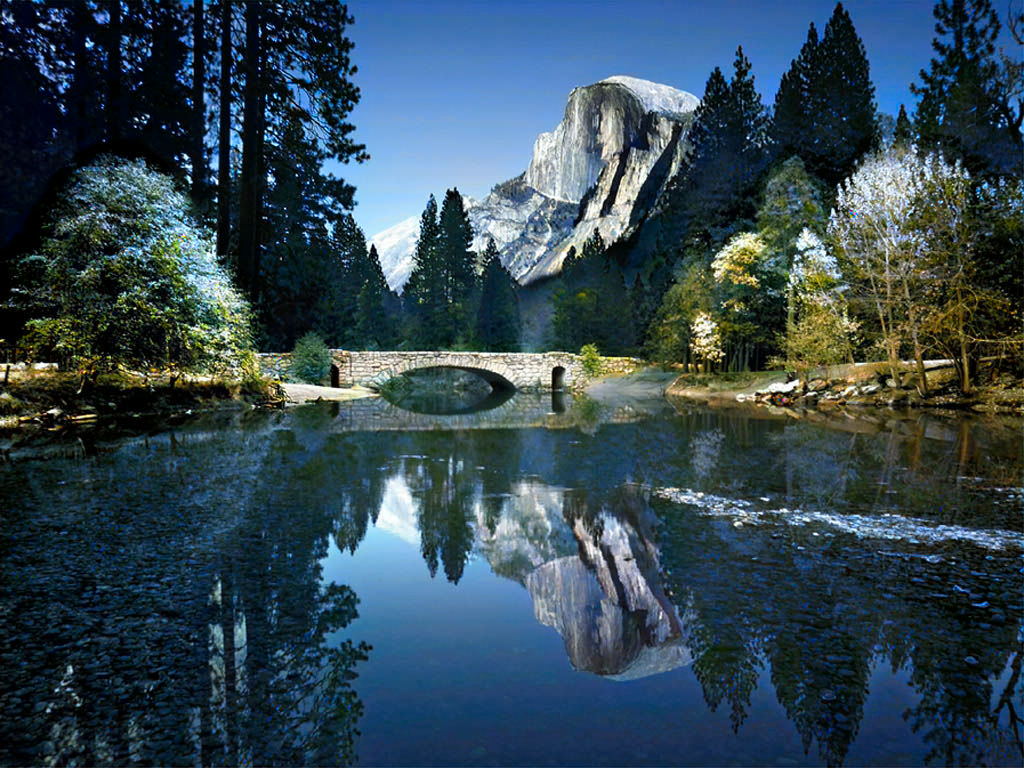

In [17]:
from IPython.display import display

if OV_INT8_COLORIZER_PATH.exists():
    compiled_int8_model = core.compile_model(OV_INT8_COLORIZER_PATH, device.value)
    img = cv2.imread("DDColor/assets/test_images/Ansel Adams _ Moore Photography.jpeg")
    img_out = process(img, compiled_int8_model)
    display(PIL.Image.fromarray(img_out[:, :, ::-1]))

## Compare FP16 and INT8 model size
[back to top ⬆️](#Table-of-contents:)

In [18]:
fp16_ir_model_size = OV_COLORIZER_PATH.with_suffix(".bin").stat().st_size / 2**20

print(f"FP16 model size: {fp16_ir_model_size:.2f} MB")

if OV_INT8_COLORIZER_PATH.exists():
    quantized_model_size = OV_INT8_COLORIZER_PATH.with_suffix(".bin").stat().st_size / 2**20
    print(f"INT8 model size: {quantized_model_size:.2f} MB")
    print(f"Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

FP16 model size: 104.81 MB
INT8 model size: 52.93 MB
Model compression rate: 1.980


## Compare inference time of the FP16 and INT8 models
[back to top ⬆️](#Table-of-contents:)

To measure the inference performance of OpenVINO FP16 and INT8 models, use [Benchmark Tool](https://docs.openvino.ai/2024/learn-openvino/openvino-samples/benchmark-tool.html).

> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications.

In [19]:
!benchmark_app  -m $OV_COLORIZER_PATH -d $device.value -api async -shape "[1,3,512,512]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2025.0.0-17765-66f1b2487a3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2025.0.0-17765-66f1b2487a3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 48.32 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [1,3,512,512]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.refine_net.0.0/aten::_convolution/Add) : f32 / [...] / [1,2,512,512]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[ INFO ] R

In [20]:
if OV_INT8_COLORIZER_PATH.exists():
    !benchmark_app  -m $OV_INT8_COLORIZER_PATH -d $device.value -api async -shape "[1,3,512,512]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2025.0.0-17765-66f1b2487a3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2025.0.0-17765-66f1b2487a3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 79.43 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [1,3,512,512]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.refine_net.0.0/aten::_convolution/Add) : f32 / [...] / [1,2,512,512]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch size: 1
[ INFO ] R

## Interactive inference
[back to top ⬆️](#Table-of-contents:)

In [21]:
def generate(image, use_int8=True):
    image_in = cv2.imread(image)
    image_out = process(image_in, compiled_model if not use_int8 else compiled_int8_model)
    image_out_pil = PIL.Image.fromarray(cv2.cvtColor(image_out, cv2.COLOR_BGR2RGB))
    return image_out_pil


if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/ddcolor-image-colorization/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo

demo = make_demo(fn=generate, quantized=compiled_int8_model is not None)

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

Keyboard interruption in main thread... closing server.
